In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option("display.max_columns", 85)
sns.set_theme(context="paper", font_scale=1.5, style="ticks", rc={"axes.grid": True})


# Calculating Feature Importance by Coefficients

#### Basic theory

The importance of a given feature to a logistic regressor can be assessed by finding the largest coefficients of its variables (as long as the features are scaled). If we apply our PCA, the coefficients will correspond to the sum of mutations variable, the age variable, and the principal components.

#### Notebook summary

This notebook calculates logistic regression coefficients (betas) for the following models:
- Logistic Regression with no regularization in pipeline with Scaling and 100% EV PCA 
- Logistic Regression with no regularization in pipeline with Scaling and no PCA

The data used in these experiments:
- Two foundational features: occ_total_sum and oldest_phylostratum
- 80 confounder variables including trinucleotidic frequencies. 
- Dropped from ACC to UVM
- Dropped oldest_phylostratum_factor
- Dropped TTT_freq
- Dropped gc_cds
- Dropped NaNs

In the directory `./data/lr/` this notebook saves the following files:
- `lr_betas.csv` (coefficients of features and PCs)
- `lr_loadings` (loadings of the PCs calculated in this first experiment)
- `lr_betas_no_pca` (coefficients of each feature for the second experiment, no pca)

***
## Load the data

In [2]:
# Read Data from CSV (NEW DATA, NOT SCALED)
df = pd.read_csv("../data/abnormal_writeout_noscale.data.csv", index_col=0)

# trascurare da ACC a UVM
start_drop = df.columns.get_loc("ACC")
end_drop = df.columns.get_loc("UVM")
cols = np.arange(start_drop, end_drop + 1)
df.drop(df.columns[cols], axis=1, inplace=True)

# trascurare alcune colonne
df.drop("TTT_freq", axis=1, inplace=True) 
df.drop("oldest_phylostratum_factor", axis=1, inplace=True)
df.drop("gc_cds", axis=1, inplace=True) # ! New

# Drop NaNs
df.dropna(inplace=True)

# Sort features
resp = df["response"]
occ = df["occ_total_sum"]
age = df["oldest_phylostratum"]
conf = df.drop(labels=["response", "occ_total_sum", "oldest_phylostratum"], axis=1)

# Collect Features and Labels
features_df = pd.DataFrame()
features_df["occ_total_sum"] = occ
features_df["oldest_phylostratum"] = age
features_df = pd.concat([features_df, conf], axis=1)

X = features_df.to_numpy()
y = df["response"].to_numpy()

features_df.head(5)

,occ_total_sum,oldest_phylostratum,cds_length,dnase_gene,dnase_cds,H3k4me1_gene,H3k4me3_gene,H3k27ac_gene,H3k4me1_cds,H3k4me3_cds,H3k27ac_cds,lamin_gene,repli_gene,nsome_gene,nsome_cds,transcription_gene,repeat_gene,repeat_cds,recomb_gene,AAA_freq,AAC_freq,AAG_freq,AAT_freq,ACA_freq,ACC_freq,ACG_freq,ACT_freq,AGA_freq,AGC_freq,AGG_freq,AGT_freq,ATA_freq,ATC_freq,ATG_freq,ATT_freq,CAA_freq,CAC_freq,CAG_freq,CAT_freq,CCA_freq,CCC_freq,CCG_freq,CCT_freq,CGA_freq,CGC_freq,CGG_freq,CGT_freq,CTA_freq,CTC_freq,CTG_freq,CTT_freq,GAA_freq,GAC_freq,GAG_freq,GAT_freq,GCA_freq,GCC_freq,GCG_freq,GCT_freq,GGA_freq,GGC_freq,GGG_freq,GGT_freq,GTA_freq,GTC_freq,GTG_freq,GTT_freq,TAA_freq,TAC_freq,TAG_freq,TAT_freq,TCA_freq,TCC_freq,TCG_freq,TCT_freq,TGA_freq,TGC_freq,TGG_freq,TGT_freq,TTA_freq,TTC_freq,TTG_freq
1,33,12.0,1488,0.612230,0.758065,0.561429,1.000000,0.216855,0.661290,1.000000,0.198925,0.0,0.041809,0.809254,0.706453,6.798234,0.040516,0.0,0.000000,0.004755,0.008152,0.007473,0.002717,0.011549,0.026495,0.010870,0.008152,0.010190,0.028533,0.019701,0.009511,0.000679,0.006114,0.010870,0.002038,0.009511,0.019022,0.028533,0.007473,0.027174,0.031250,0.025136,0.029891,0.015625,0.027174,0.019701,0.009511,0.007473,0.017663,0.044837,0.013587,0.008832,0.021739,0.031250,0.008152,0.016984,0.033967,0.027853,0.034647,0.023777,0.030571,0.029212,0.013587,0.000679,0.012908,0.027174,0.003397,0.000000,0.008152,0.000000,0.001359,0.008832,0.021739,0.009511,0.010190,0.020380,0.027174,0.029212,0.010870,0.000679,0.013587,0.005435
10,28,1.0,873,0.086769,0.195876,0.657839,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,-0.007148,0.828752,1.097018,0.061963,0.002809,0.0,2.043350,0.025258,0.019518,0.021814,0.024110,0.025258,0.018370,0.003444,0.012629,0.035591,0.009185,0.016073,0.006889,0.016073,0.017222,0.010333,0.033295,0.019518,0.011481,0.020666,0.022962,0.017222,0.008037,0.002296,0.021814,0.003444,0.001148,0.004592,0.002296,0.008037,0.019518,0.022962,0.019518,0.033295,0.013777,0.019518,0.011481,0.014925,0.006889,0.000000,0.012629,0.018370,0.011481,0.017222,0.018370,0.005741,0.008037,0.012629,0.012629,0.012629,0.014925,0.006889,0.017222,0.017222,0.016073,0.005741,0.022962,0.020666,0.012629,0.027555,0.011481,0.021814,0.017222,0.026406
100,36,1.0,1092,0.479295,0.611722,0.851369,0.354628,0.618954,0.754579,0.030220,0.086996,0.0,0.040463,1.249600,1.354306,6.081620,0.028404,0.0,0.868383,0.018727,0.012172,0.023408,0.003745,0.017790,0.024345,0.007491,0.014981,0.024345,0.020599,0.025281,0.011236,0.003745,0.013109,0.019663,0.004682,0.017790,0.016854,0.029963,0.017790,0.034644,0.022472,0.010300,0.028090,0.005618,0.010300,0.014045,0.003745,0.015918,0.015918,0.033708,0.011236,0.014981,0.022472,0.026217,0.009363,0.015918,0.031835,0.007491,0.025281,0.028090,0.029026,0.021536,0.013109,0.008427,0.010300,0.016854,0.003745,0.006554,0.012172,0.005618,0.008427,0.014981,0.016854,0.009363,0.008427,0.014981,0.019663,0.029026,0.010300,0.004682,0.010300,0.004682
1000,126,1.0,2800,0.171524,0.280357,0.554023,0.052420,0.278492,0.270357,0.021429,0.151429,0.0,-0.022495,0.921420,1.382249,2.254471,0.014520,0.0,1.143060,0.022054,0.014823,0.022415,0.024946,0.022054,0.014100,0.006146,0.015546,0.024946,0.016992,0.012292,0.015907,0.013377,0.021330,0.026392,0.017715,0.026392,0.011931,0.027477,0.017354,0.023861,0.016992,0.006508,0.019161,0.005785,0.003977,0.007954,0.003977,0.006146,0.010846,0.025307,0.015907,0.022415,0.022777,0.016269,0.018800,0.015184,0.016992,0.004700,0.014461,0.017354,0.010484,0.010123,0.011931,0.009400,0.007231,0.020607,0.011931,0.013738,0.008315,0.006146,0.016631,0.022054,0.018077,0.004700,0.009038,0.031092,0.019523,0.019523,0.016992,0.016269,0.014100,0.015907
10000,55,1.0,1484,0.143843,0.030997,0.400789,0.106455,0.457949,0.708221,0.030997,0.659704,0.0,-0.000387,0.960747,1.196871,1.080241,0.009545,0.0,4.217000,0.039835,0.015797,0.030220,0.025412,0.024038,0.012363,0.002747,0.019918,0.048077,0.006868,0.015797,0.009615,0.020604,0.009615,0.032280,0.023352,0.019918,0.012363,0.021978,0

## Custom PCA

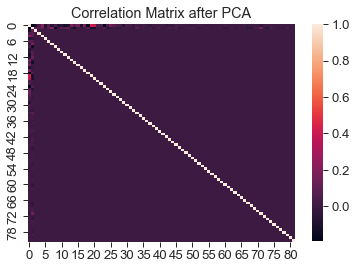

,occ_total_sum,oldest_phylostratum,cds_length,dnase_gene,dnase_cds,H3k4me1_gene,H3k4me3_gene,H3k27ac_gene,H3k4me1_cds,H3k4me3_cds,H3k27ac_cds,lamin_gene,repli_gene,nsome_gene,nsome_cds,transcription_gene,repeat_gene,repeat_cds,recomb_gene,AAA_freq,AAC_freq,AAG_freq,AAT_freq,ACA_freq,ACC_freq,ACG_freq,ACT_freq,AGA_freq,AGC_freq,AGG_freq,AGT_freq,ATA_freq,ATC_freq,ATG_freq,ATT_freq,CAA_freq,CAC_freq,CAG_freq,CAT_freq,CCA_freq,CCC_freq,CCG_freq,CCT_freq,CGA_freq,CGC_freq,CGG_freq,CGT_freq,CTA_freq,CTC_freq,CTG_freq,CTT_freq,GAA_freq,GAC_freq,GAG_freq,GAT_freq,GCA_freq,GCC_freq,GCG_freq,GCT_freq,GGA_freq,GGC_freq,GGG_freq,GGT_freq,GTA_freq,GTC_freq,GTG_freq,GTT_freq,TAA_freq,TAC_freq,TAG_freq,TAT_freq,TCA_freq,TCC_freq,TCG_freq,TCT_freq,TGA_freq,TGC_freq,TGG_freq,TGT_freq,TTA_freq,TTC_freq,TTG_freq
1,33,12.0,1488,0.612230,0.758065,0.561429,1.000000,0.216855,0.661290,1.000000,0.198925,0.0,0.041809,0.809254,0.706453,6.798234,0.040516,0.0,0.000000,0.004755,0.008152,0.007473,0.002717,0.011549,0.026495,0.010870,0.008152,0.010190,0.028533,0.019701,0.009511,0.000679,0.006114,0.010870,0.002038,0.009511,0.019022,0.028533,0.007473,0.027174,0.031250,0.025136,0.029891,0.015625,0.027174,0.019701,0.009511,0.007473,0.017663,0.044837,0.013587,0.008832,0.021739,0.031250,0.008152,0.016984,0.033967,0.027853,0.034647,0.023777,0.030571,0.029212,0.013587,0.000679,0.012908,0.027174,0.003397,0.000000,0.008152,0.000000,0.001359,0.008832,0.021739,0.009511,0.010190,0.020380,0.027174,0.029212,0.010870,0.000679,0.013587,0.005435
10,28,1.0,873,0.086769,0.195876,0.657839,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,-0.007148,0.828752,1.097018,0.061963,0.002809,0.0,2.043350,0.025258,0.019518,0.021814,0.024110,0.025258,0.018370,0.003444,0.012629,0.035591,0.009185,0.016073,0.006889,0.016073,0.017222,0.010333,0.033295,0.019518,0.011481,0.020666,0.022962,0.017222,0.008037,0.002296,0.021814,0.003444,0.001148,0.004592,0.002296,0.008037,0.019518,0.022962,0.019518,0.033295,0.013777,0.019518,0.011481,0.014925,0.006889,0.000000,0.012629,0.018370,0.011481,0.017222,0.018370,0.005741,0.008037,0.012629,0.012629,0.012629,0.014925,0.006889,0.017222,0.017222,0.016073,0.005741,0.022962,0.020666,0.012629,0.027555,0.011481,0.021814,0.017222,0.026406
100,36,1.0,1092,0.479295,0.611722,0.851369,0.354628,0.618954,0.754579,0.030220,0.086996,0.0,0.040463,1.249600,1.354306,6.081620,0.028404,0.0,0.868383,0.018727,0.012172,0.023408,0.003745,0.017790,0.024345,0.007491,0.014981,0.024345,0.020599,0.025281,0.011236,0.003745,0.013109,0.019663,0.004682,0.017790,0.016854,0.029963,0.017790,0.034644,0.022472,0.010300,0.028090,0.005618,0.010300,0.014045,0.003745,0.015918,0.015918,0.033708,0.011236,0.014981,0.022472,0.026217,0.009363,0.015918,0.031835,0.007491,0.025281,0.028090,0.029026,0.021536,0.013109,0.008427,0.010300,0.016854,0.003745,0.006554,0.012172,0.005618,0.008427,0.014981,0.016854,0.009363,0.008427,0.014981,0.019663,0.029026,0.010300,0.004682,0.010300,0.004682
1000,126,1.0,2800,0.171524,0.280357,0.554023,0.052420,0.278492,0.270357,0.021429,0.151429,0.0,-0.022495,0.921420,1.382249,2.254471,0.014520,0.0,1.143060,0.022054,0.014823,0.022415,0.024946,0.022054,0.014100,0.006146,0.015546,0.024946,0.016992,0.012292,0.015907,0.013377,0.021330,0.026392,0.017715,0.026392,0.011931,0.027477,0.017354,0.023861,0.016992,0.006508,0.019161,0.005785,0.003977,0.007954,0.003977,0.006146,0.010846,0.025307,0.015907,0.022415,0.022777,0.016269,0.018800,0.015184,0.016992,0.004700,0.014461,0.017354,0.010484,0.010123,0.011931,0.009400,0.007231,0.020607,0.011931,0.013738,0.008315,0.006146,0.016631,0.022054,0.018077,0.004700,0.009038,0.031092,0.019523,0.019523,0.016992,0.016269,0.014100,0.015907
10000,55,1.0,1484,0.143843,0.030997,0.400789,0.106455,0.457949,0.708221,0.030997,0.659704,0.0,-0.000387,0.960747,1.196871,1.080241,0.009545,0.0,4.217000,0.039835,0.015797,0.030220,0.025412,0.024038,0.012363,0.002747,0.019918,0.048077,0.006868,0.015797,0.009615,0.020604,0.009615,0.032280,0.023352,0.019918,0.012363,0.021978,0

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

class ConfounderPCA(BaseEstimator, TransformerMixin):
    """ 
    Custom PCA transformer for this dataset.
    Applies PCA only to the many collinear confounder 
    variables.
    
    cols - columns to which PCA will be applied.
    
    n_components - same as with the "vanilla" PCA. 
        If 0 < n_components < 1, select the number of 
        components such that the amount of variance that 
        needs to be explained is greater than the 
        percentage specified by n_components.
        
    apply_PCA - if false, simply returns the untransformed data.
    """

    def __init__(self, cols, n_components=None, apply_PCA=True):
        self.n_components = n_components
        self.apply_PCA = apply_PCA
        self.cols = cols
        if self.apply_PCA:
            self.pca = PCA(n_components=self.n_components)

    def fit(self, X, y=None):
        if self.apply_PCA:
            self.pca.fit(X[:, self.cols])
        return self

    def transform(self, X, y=None):
        if self.apply_PCA:
            X_pca = self.pca.transform(X[:, self.cols])
            return np.c_[X[:, :2], X_pca]
        else:
            return X

sns.heatmap(
    pd.DataFrame(
        ConfounderPCA(cols=np.arange(2, X.shape[1])).fit_transform(StandardScaler().fit_transform(X))
    ).corr()
)
plt.title("Correlation Matrix after PCA")
plt.show()

features_df

## Train-Test Split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (14536, 82) (14536,)
Testing set shape: (3634, 82) (3634,)


# Coefficients of Principal Components

### Model Definition, Training, and Coefficient Extraction

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Model definition
lr_clf = Pipeline([
    # Apply scaling
    ("scaler", StandardScaler()),
    # Then apply PCA to the confounder variables, keeping all principal components
    ("pca", ConfounderPCA(n_components=None, cols=np.arange(2, X.shape[1]))),
    # Fit the l2 regularized logistic regression
    ("lr", LogisticRegression(max_iter=2000, penalty='none')),
])

# Model training
lr_clf.fit(X_train, y_train)

# Extract Coefficients (i.e. betas) from Trained Model

# Collect the coefficients into a pandas dataframe
coef_df = pd.DataFrame(lr_clf["lr"].coef_.T, columns=["beta"])

# Label the first two variables, and name the PCs "PC 1", etc
coef_df.rename(index={0 : "occ_total_sum", 1 : "oldest_phylostratum"}, inplace=True)
coef_df.rename(index=lambda s: s-1 if isinstance(s, int) else s, inplace=True)
coef_df.rename(index=lambda s: f"PC {s}" if isinstance(s, int) else s, inplace=True)

# Save the coefficients
coef_df.to_csv("./data/lr/lr_betas.csv")

# Print the dataframe sorted by absolute value of coefficients
coef_df.sort_values(by="beta", key=abs, ascending=False).head(5)

,beta
PC 79,2.145719
PC 70,1.921622
PC 77,1.671911
PC 69,-1.465592
PC 73,-1.112878


### PC Loadings

In [6]:
# collect the loadings of the pca object into a pandas dataframe
loadings_df = pd.DataFrame(lr_clf["pca"].pca.components_.T, index = features_df.columns[2:])

# Rename PCs
loadings_df.rename(columns=lambda s: f"PC {s+1}", inplace=True)
loadings_df.to_csv("./data/lr/lr_loadings.csv")

# Get the indices of the top principal components
idx = coef_df[2:].sort_values(by="beta", key=abs, ascending=False).index

print("Top Loadings of top PCs")
N = 2
sorted_loadings_df = loadings_df.loc[:, idx].T
for i in range(N):
    print(sorted_loadings_df.iloc[i, :].sort_values(axis=0,key=abs, ascending=False)[0:4])

Top Loadings of top PCs
TAT_freq    0.381693
TTA_freq   -0.376210
ATA_freq   -0.369122
TAA_freq    0.351458
Name: PC 79, dtype: float64
GAA_freq    0.427336
AGA_freq   -0.320590
TGA_freq   -0.318394
TGG_freq   -0.313536
Name: PC 70, dtype: float64


### Heatmap of Loading/Rotation Matrix

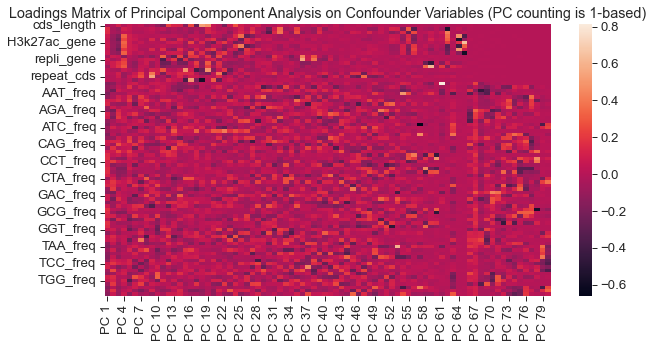

In [7]:
plt.figure(figsize=(10,5))
sns.heatmap(loadings_df)
plt.title("Loadings Matrix of Principal Component Analysis on Confounder Variables (PC counting is 1-based)")
plt.show()

# Coefficients of Features (Without PCA)

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Model definition
lr_clf = Pipeline([
    # Apply scaling
    ("scaler", StandardScaler()),
    # ! -- Don't apply PCA
    # Fit the l2 regularized logistic regression
    ("lr", LogisticRegression(max_iter=2000, penalty='none')),
])

# Model training
lr_clf.fit(X_train, y_train)


# Extract Coefficients (i.e. betas) from Trained Model

# Collect the coefficients into a pandas dataframe
coef_df = pd.DataFrame(lr_clf["lr"].coef_.T, columns=["beta"], index=features_df.columns)

# Save the coefficients
coef_df.to_csv("./data/lr/lr_betas_no_pca.csv")

# Print the dataframe sorted by absolute value of coefficients
coef_df.sort_values(by="beta", key=abs, ascending=False).head(5)

,beta
TAT_freq,1.137112
TGT_freq,-1.104310
GTG_freq,1.055988
ATA_freq,-1.028996
CCA_freq,0.836370
